In [19]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load the JSON file
data = pd.read_json('./VUEs_mskimpact_genie.json')

# Convert to a DataFrame
df = pd.DataFrame(data)


# Normalize the 'revisedProteinEffects' column
normalized_dfs = []
for index, row in df.iterrows():
    normalized_row = pd.json_normalize(row['revisedProteinEffects'])
    repeated_row = pd.DataFrame([row.drop('revisedProteinEffects')] * len(normalized_row)).reset_index(drop=True)
    combined = pd.concat([repeated_row.reset_index(drop=True), normalized_row], axis=1).reset_index(drop=True)
    normalized_dfs.append(combined)

# Determine the union of all column names
all_columns = set()
for df in normalized_dfs:
    all_columns.update(df.columns)

# Reindex each DataFrame to include all columns, filling missing values with NaN
all_columns = list(all_columns)
for i, df in enumerate(normalized_dfs):
    normalized_dfs[i] = df.loc[:, ~df.columns.duplicated()].reindex(columns=all_columns)

# Concatenate all normalized DataFrames
result_df = pd.concat(normalized_dfs, ignore_index=True)
# make anything CountByVariantCount 0
count_cancer_type_columns = [col for col in result_df.columns if 'CountByCancerType' in col]
result_df[count_cancer_type_columns] = result_df[count_cancer_type_columns].fillna(0).astype(int)

In [20]:
# hardcoded set o fgene swith highest level (manually determined with
# mutationmapper, and just looking upn genes in OncoKB)
highest_level_per_gene = {
    "KIT": "Level 1",
    "MET": "Level 1",
    "FLT3": "Level 1",
    "ATM": "Level 1",
    "BRCA1": "Level 1",
    "BRCA2": "Level 1",
    "BRIP1": "Level 1",
    "CHEK2": "Level 1",
    "PALB2": "Level 1",
    "RAD51D": "Level 1",
    "MLH1": "Level 1",
    "EGFR": "Level 1",
    "KRAS": "Level 1",
}

In [21]:
# total is mskimpact + mskimpact_nonsignedout + genie (unique patients)
target_cohorts = ['total']

In [22]:
# Custom function to calculate the sum
def custom_sum(row):
    result = {}
    for study in target_cohorts:
        result[study] = (
            row[f'counts.{study}.somaticVariantsCount'].sum() +
            row[f'counts.{study}.germlineVariantsCount'].sum() +
            row[f'counts.{study}.unknownVariantsCount'].sum()
        )
        # result[f'{study}.totalPatientCount'] = row[f'counts.{study}.totalPatientCount'].values[0]
        
    for cancer_type in cancer_types:
        result[f'counts.CancerType.{cancer_type}'] = 0
        for study in target_cohorts:
            result[f'counts.CancerType.{cancer_type}'] += (
                row.get(f'counts.{study}.somaticVariantsCountByCancerType.{cancer_type}', np.array(0)).sum() +
                row.get(f'counts.{study}.germlineVariantsCountByCancerType.{cancer_type}', np.array(0)).sum() +
                row.get(f'counts.{study}.unknownVariantsCountByCancerType.{cancer_type}', np.array(0)).sum()
            )
    return pd.Series(result)

cancer_types = set([c.split('.')[-1] for c in result_df.columns if "CancerType" in c])

# Group by 'hugoGeneSymbol' and apply custom function
grouped_df = result_df.groupby('hugoGeneSymbol').apply(custom_sum)

# Add additional columns
grouped_df['Number of VUEs'] = result_df.groupby('hugoGeneSymbol').size()
grouped_df['total_variant_count'] = grouped_df[target_cohorts].sum(axis=1)
grouped_df['Highest_Level'] = grouped_df.index.map(highest_level_per_gene).fillna('Oncogenic')
grouped_df['total_patient_count'] = grouped_df['total_variant_count']

# remove TERT because it has too many found
grouped_df.drop(index=['TERT'], inplace=True, errors='ignore')

grouped_df.head(30)


,total,counts.CancerType.Sellar Tumor,counts.CancerType.Salivary Gland Cancer,counts.CancerType.Desmoplastic/Nodular Medulloblastoma,counts.CancerType.Uterine Sarcoma,counts.CancerType.Nerve Sheath Tumor,counts.CancerType.Melanoma,counts.CancerType.Esophagogastric Cancer,counts.CancerType.Breast Sarcoma,counts.CancerType.Ovarian Cancer,...,counts.CancerType.Retinoblastoma,counts.CancerType.Cervical Cancer,counts.CancerType.Hodgkin Lymphoma,counts.CancerType.Sex Cord Stromal Tumor,counts.CancerType.Neoplastic Vs Reactive,counts.CancerType.Ampullary Cancer,Number of VUEs,total_variant_count,Highest_Level,total_patient_count
hugoGeneSymbol,,,,,,,,,,,,,,,,,,,,,
APC,513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,513.0,Oncogenic,513.0
ATM,31.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,10,31.0,Level 1,31.0
BAP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,Oncogenic,0.0
BRCA1,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9,17.0,Level 1,17.0
BRCA2,19.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9,19.0,Level 1,19.0
BRIP1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,2.0,Level 1,2.0
CDH1,26.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,26.0,Oncogenic,26.0
CHEK2,17.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,17.0,Level 1,17.0
CTNNB1,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21,15.0,Oncogenic,15.0


In [23]:
import os
# count the number of unique patients by cancer type and cohort
COHORTS = {
    "mskimpact": {
        "clinical": "../../../scripts/files/mskimpact/mskimpact_data_clinical_sample.txt",
        "gene_panel_col": "GENE_PANEL",
        "target_panels": ["IMPACT341", "IMPACT410", "IMPACT468", "IMPACT505"]
    },
    "mskimpact_nonsignedout": {
        "clinical": "../../../scripts/files/mskimpact_nonsignedout/data_clinical_sample.txt",
        "gene_panel_col": "GENE_PANEL",
        "target_panels": ["IMPACT341", "IMPACT410", "IMPACT468", "IMPACT505"]
    },
    "genie": {
        "clinical": "../../../scripts/files/genie/genie_data_clinical_sample.txt",
        "gene_panel_col": "SEQ_ASSAY_ID",
        "target_panels": None
    },
    "tcga": {
        "folder": "../../../scripts/files/tcga",
        "gene_panel_col": None,
        "target_panels": None
    }
}

def read_clinical_df(path, gene_panel_col=None, target_panels=None):
    patien_count_df = pd.read_csv(path, sep="\t", low_memory=False)
    if target_panels and gene_panel_col and gene_panel_col in patien_count_df.columns:
        patien_count_df = patien_count_df[patien_count_df[gene_panel_col].isin(target_panels)]
    patien_count_df[['PATIENT_ID']] = patien_count_df[['PATIENT_ID']].apply(
        lambda col: col.str.replace("GENIE-MSK-", "", regex=False)
    )
    return patien_count_df[['PATIENT_ID', 'CANCER_TYPE']].drop_duplicates()

cohort_clinical_data = {}

for cohort, config in COHORTS.items():
    print(f"Loading {cohort}...")
    if cohort == "tcga":
        clinical_files = [
            os.path.join(config["folder"], f)
            for f in os.listdir(config["folder"])
            if f.endswith("_clinical_samples.txt")
        ]
        df_list = [
            read_clinical_df(path, config.get("gene_panel_col"), config.get("target_panels"))
            for path in clinical_files
        ]
        clinical_df = pd.concat(df_list, ignore_index=True)
    else:
        clinical_df = read_clinical_df(
            config["clinical"],
            config.get("gene_panel_col"),
            config.get("target_panels")
        )
    cohort_clinical_data[cohort] = clinical_df

result_data = {}

for cohort, patien_count_df in cohort_clinical_data.items():
    counts = patien_count_df.groupby("CANCER_TYPE")["PATIENT_ID"].nunique().to_dict()
    for cancer_type, count in counts.items():
        result_data[f"{cohort}.{cancer_type}"] = count

# Compute combined counts
# mskimpact_combined: mskimpact + mskimpact_nonsignedout
# mskimpact_genie_combined: mskimpact + mskimpact_nonsignedout + genie
# total: mskimpact + mskimpact_nonsignedout + genie + tcga
combined_groups = {
    "mskimpact_combined": ["mskimpact", "mskimpact_nonsignedout"],
    "mskimpact_genie_combined": ["mskimpact", "mskimpact_nonsignedout", "genie"],
    "total": list(cohort_clinical_data.keys())
}

for combined_label, members in combined_groups.items():
    combined_df = pd.concat([cohort_clinical_data[c] for c in members], ignore_index=True)
    counts = combined_df.groupby("CANCER_TYPE")["PATIENT_ID"].nunique().to_dict()
    for cancer_type, count in counts.items():
        result_data[f"{combined_label}.{cancer_type}"] = count

patien_count_df_out = pd.DataFrame.from_dict(result_data, orient="index", columns=["patient_count"])
patien_count_df_out.index.name = "Cohort.CancerType"
patien_count_df_out.sort_index(inplace=True)
patien_count_df_out

Loading mskimpact...
Loading mskimpact_nonsignedout...
Loading genie...
Loading tcga...


,patient_count
Cohort.CancerType,
genie.Adenocarcinoma In Situ,4
genie.Adrenal Gland Cancer,3
genie.Adrenocortical Adenoma,33
genie.Adrenocortical Carcinoma,261
genie.Ampullary Cancer,392
...,...
total.Uterine Sarcoma,877
total.Vaginal Cancer,215
total.Vulvar Carcinoma,4


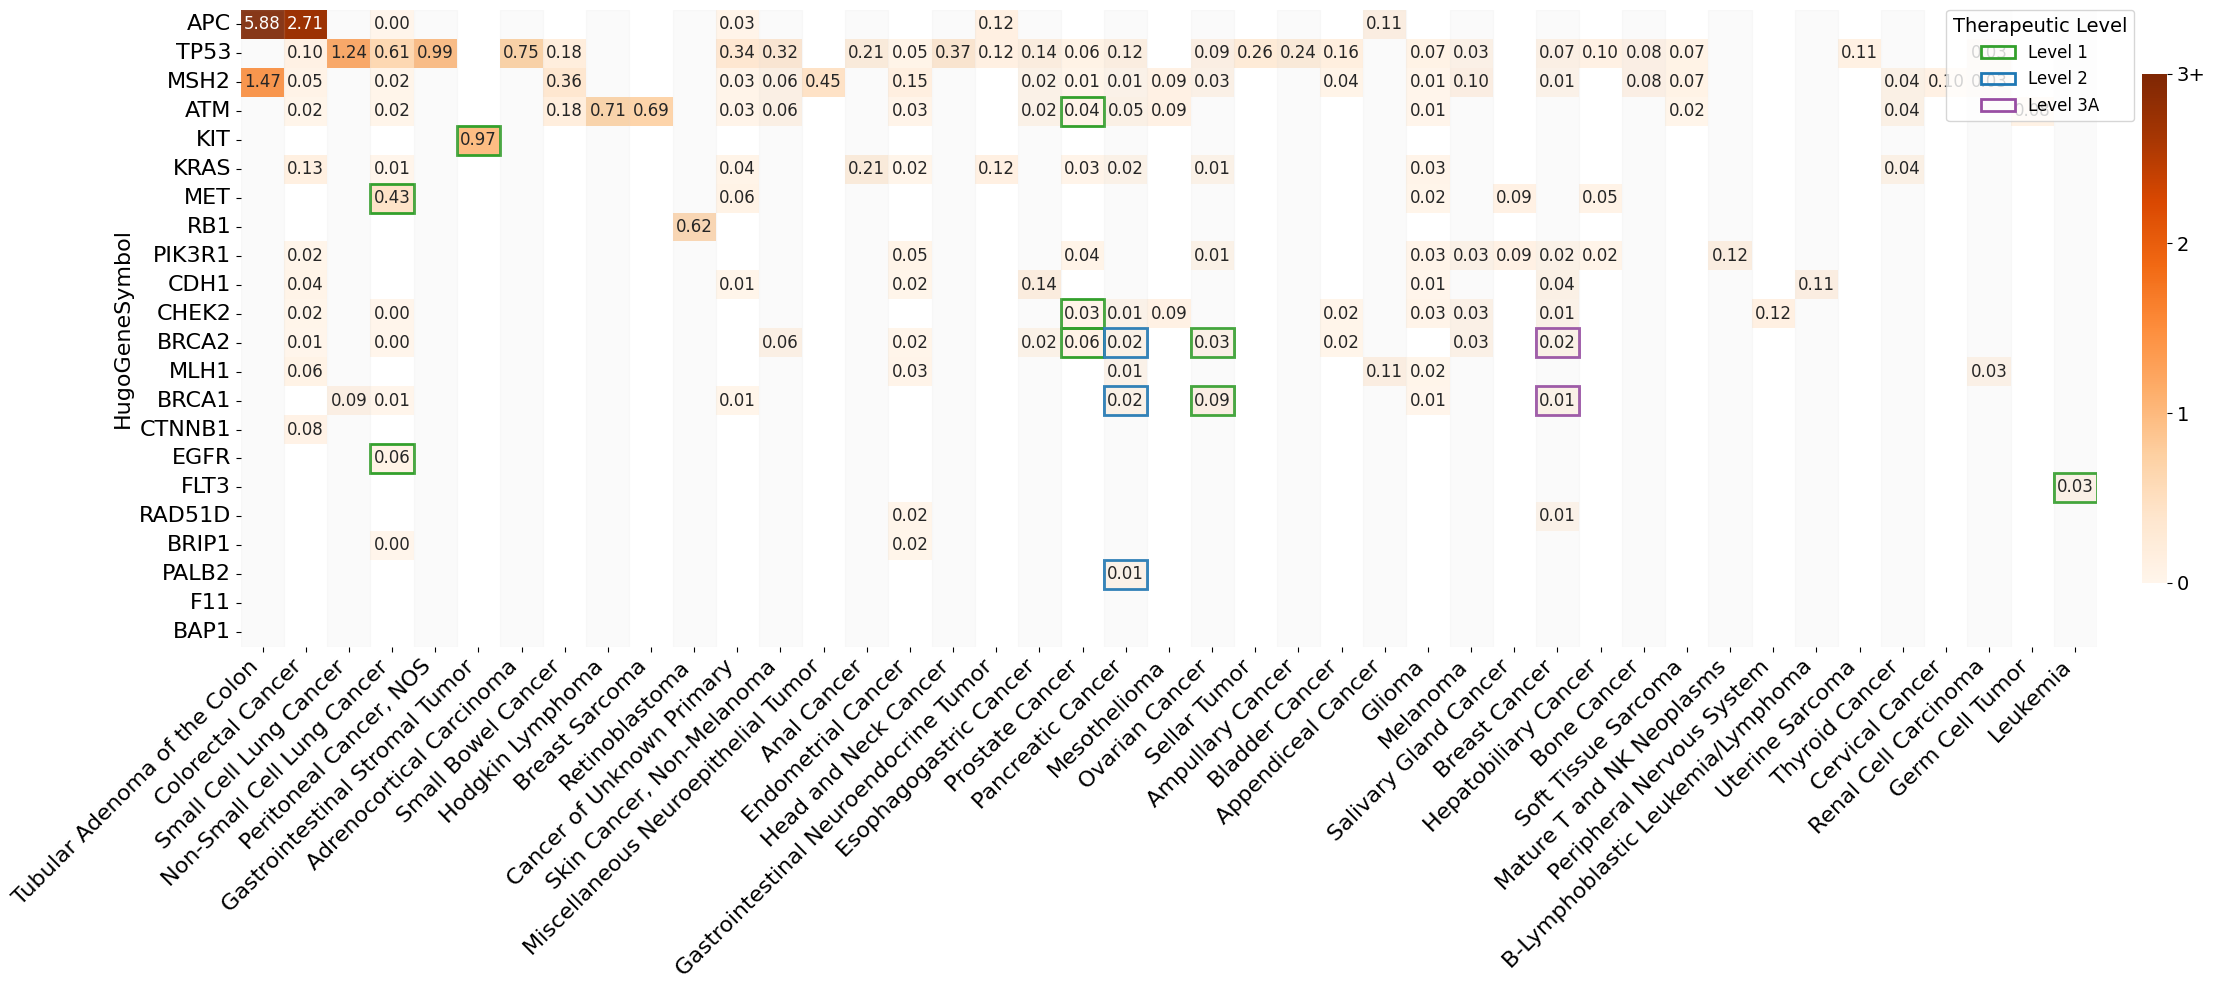

In [24]:
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

level_palette = {
    'Level 1': '#33A02C',
    'Level 2': '#1F78B4',
    'Level 3A': '#984EA3',
    'Level 3B': '#BE98CE',
    'Level 4': '#424242',
    'R1': '#EE3424',
    'R2': '#F79A92',
    'R3': '#FCD6D3' 
}

highlight_map = {
    'APC': {},
    'ATM': {'Prostate Cancer': 'Level 1'},
    'BAP1': {},
    'BRCA1': {
        'Prostate Cancer': 'Level 1',
        'Ovarian Cancer': 'Level 1',
        'Pancreatic Cancer': 'Level 2',
        'Breast Cancer': 'Level 3A'
    },
    'BRCA2': {
        'Prostate Cancer': 'Level 1',
        'Ovarian Cancer': 'Level 1',
        'Pancreatic Cancer': 'Level 2',
        'Uterine Sarcoma': 'Level 1',
        'Breast Cancer': 'Level 3A'
    },
    'BRIP1': {'Prostate Cancer': 'Level 1'},
    'CDH1': {},
    'CHEK2': {'Prostate Cancer': 'Level 1'},
    'CTNNB1': {},
    'EGFR': {
        'Non-Small Cell Lung Cancer': 'Level 1',
        'Esophagogastric Cancer': 'Level 3A',
        'Glioma': 'Level 4',
        'Colorectal Cancer': 'R2'
    },
    'F11': {},
    'FLT3': {'Leukemia': 'Level 1'},
    'KIT': {
        'Gastrointestinal Stromal Tumor': 'Level 1',
        'Mastocytosis': 'Level 1',
        'Melanoma': 'Level 2'
    },
    'KRAS': {},
    'MET': {'Non-Small Cell Lung Cancer': 'Level 1'},
    'MLH1': {'Prostate Cancer': 'Level 1'},
    'MSH2': {},
    'PALB2': {
        'Prostate Cancer': 'Level 1',
        'Pancreatic Cancer': 'Level 2'
    },
    'PIK3R1': {},
    'RAD51D': {'Prostate Cancer': 'Level 1'},
    'RB1': {},
    'TP53': {}
}

def totol_count_sum(row):
    result = {}
    for cancer_type in cancer_types:
        result[f'counts.CancerType.{cancer_type}'] = 0
        result[f'counts.CancerType.{cancer_type}'] += (
            row.get(f'counts.total.somaticVariantsCountByCancerType.{cancer_type}', np.array(0)).sum() +
            row.get(f'counts.total.germlineVariantsCountByCancerType.{cancer_type}', np.array(0)).sum() +
            row.get(f'counts.total.unknownVariantsCountByCancerType.{cancer_type}', np.array(0)).sum()
        )
    return pd.Series(result)


heatmap_data = grouped_df.filter(like='counts.CancerType.')
heatmap_data.columns = [col.replace('counts.CancerType.', '') for col in heatmap_data.columns]
heatmap_data = heatmap_data.loc[:, heatmap_data.sum(axis=0) != 0]
for col in heatmap_data.columns:
    heatmap_data[col] = heatmap_data[col] * 100.0 / patien_count_df_out.loc[f'mskimpact_genie_combined.{col}']['patient_count']

heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]
heatmap_data = heatmap_data[heatmap_data.sum(axis=0).sort_values(ascending=False).index]


# Plot the heatmap
plt.figure(figsize=(25, 10))

# change the color palette to be evenly spaced from 0-3
capped_data = heatmap_data.copy()
capped_data = capped_data.applymap(lambda x: min(x, 3))

# Step 2: Use standard Normalize
norm = mcolors.Normalize(vmin=0, vmax=3)

# add n=10 to the x axis lables of the heatmap
ax = sns.heatmap(heatmap_data, cmap='Oranges', annot=True, fmt='.2f', mask=heatmap_data == 0, annot_kws={"fontsize": 12}, cbar_kws={'shrink': 0.8, 'pad': 0.02}, norm=norm )
# Access the colorbar and customize its ticks
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1, 2, 3])
colorbar.set_ticklabels(['0', '1', '2', '3+'])
colorbar.ax.tick_params(labelsize=14)


# Overlay colored boxes for matching gene × cancer_type × level
for row_idx, gene in enumerate(heatmap_data.index):
    for col_idx, cancer_type in enumerate(heatmap_data.columns):
        cell_value = heatmap_data.loc[gene, cancer_type]
        if cell_value == 0 or np.isnan(cell_value):
            continue

        highlight_entry = highlight_map.get(gene, {})
        if highlight_entry == 'all' or 'all' in highlight_entry:
            level = highlight_entry.get('all')
        else:
            level = highlight_entry.get(cancer_type)

        if level in level_palette:
            ax.add_patch(Rectangle(
                (col_idx, row_idx), 1, 1,
                fill=False,
                edgecolor=level_palette[level],
                linewidth=2
            ))
levels_to_show = ['Level 1', 'Level 2', 'Level 3A']
legend_patches = [
    mpatches.Patch(edgecolor=level_palette[level], facecolor='none', label=level, linewidth=2)
    for level in levels_to_show
]

# Add the legend to the plot
plt.legend(
    handles=legend_patches,
    title="Therapeutic Level",
    bbox_to_anchor=(1.02, 1),  # position legend outside right
    loc='upper right',
    borderaxespad=0.,
    fontsize=12,
    title_fontsize=14
)

# Rotate long cancer type labels
plt.xticks(rotation=45, ha='right')

# Add vertical minor ticks at cell boundaries
ax.set_xticks(np.arange(len(heatmap_data.columns)) + 0.5, minor=True)
ax.grid(which='minor', axis='x', linestyle='-', color='lightgray', linewidth=0.5)
ax.tick_params(axis='x', which='minor', bottom=False)

# Add alternating column background stripes for readability
for idx in range(0, len(heatmap_data.columns), 2):
    ax.axvspan(idx, idx + 1, color='lightgrey', alpha=0.1)

# Add y-axis ticks for horizontal line support
ax.set_yticks(np.arange(len(heatmap_data.index)) + 0.5, minor=True)
ax.grid(which='minor', axis='y', linestyle='-', color='lightgray', linewidth=0.5)
ax.tick_params(axis='y', which='minor', left=False)

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.ylabel('HugoGeneSymbol', fontsize=16)
plt.tight_layout()
plt.savefig("revue_percentage_plot_mskimpact_genie.svg", format='svg')
# plt.show()
# only msk-impact
# heatmap of APC (x is APC + tubular adenoma, y is cohorts), KIT + GIST